## Assignment GuideLine

url => https://movie.naver.com/movie/sdb/rank/rmovie.naver 

평점은 관람객 평점만 하셔도 괜찮습니다!

기자 평론가 평점의 경우는 보다 까다로울 수 있음.

제목, 평점, 주로 개요 쪽에 몰려 있음, 등급, 흥행 정보를 저장

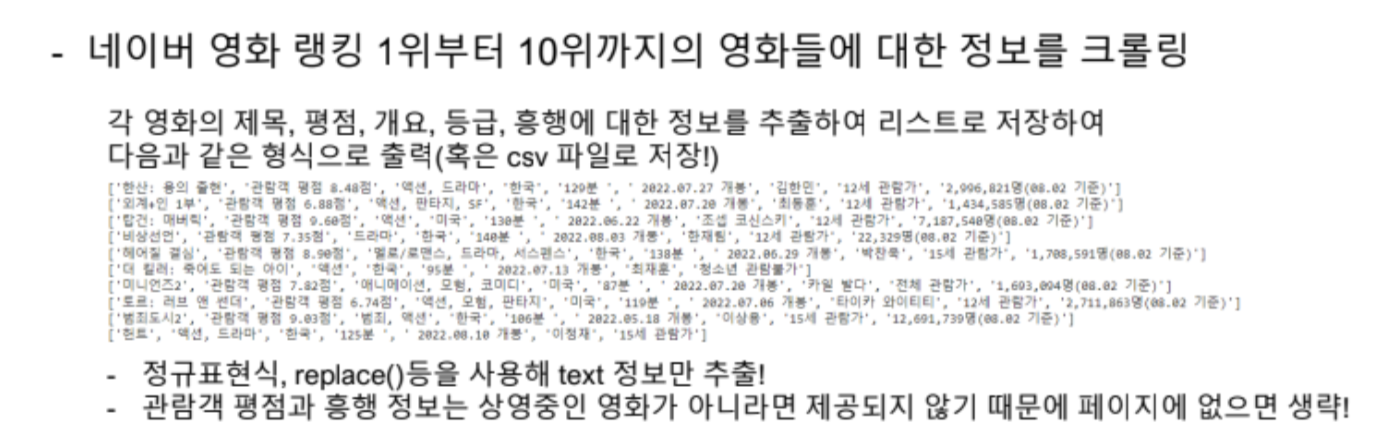

# Crawling Assignment

## Libraries Install and Import

기본적으로 Google Colab은 가상환경에서 실행되는 방식이므로 설치가 되지 않은 경우에는 설치를 진행해준다.

In [1]:
# !pip3 install requests
# !pip3 install bs4
# !pip3 install selenium

In [2]:
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm # for문의 진행상황을 확인
import time # 서버 과부하 방지
import re
import pandas as pd

### Top 50 각 영화로 이동하는 URL 정보 받아오기

In [3]:
url = 'https://movie.naver.com/movie/sdb/rank/rmovie.naver'
res = requests.get(url)

if res.status_code != 200:
    # status code가 200 아닌 경우 실행 중지
    raise

soup = BeautifulSoup(res.text, 'html.parser')
# table -> tbody -> tr -> div, class_ = 'tit3' -> a

# .find()를 진행한 후 여전히 html객체이므로 반복해 .find()를 사용할 수 있다.
# html -> html -> html -> list (containing html)
title_info = soup.find('table', class_='list_ranking').find('tbody').find_all('div', class_='tit3')

# top50 인기 영화 페이지 url을 저장
top50_links = []

# list내에서 각 anchor tag의 href 참조 링크 부분을 str type으로 가져온다.
for item in tqdm(title_info):
    top50_links.append(item.find('a')['href'])#<class 'str'>

top50_links

100%|██████████| 50/50 [00:00<00:00, 40183.02it/s]


['/movie/bi/mi/basic.naver?code=194196',
 '/movie/bi/mi/basic.naver?code=184519',
 '/movie/bi/mi/basic.naver?code=192151',
 '/movie/bi/mi/basic.naver?code=81888',
 '/movie/bi/mi/basic.naver?code=198413',
 '/movie/bi/mi/basic.naver?code=195758',
 '/movie/bi/mi/basic.naver?code=191634',
 '/movie/bi/mi/basic.naver?code=187347',
 '/movie/bi/mi/basic.naver?code=203101',
 '/movie/bi/mi/basic.naver?code=217720',
 '/movie/bi/mi/basic.naver?code=192608',
 '/movie/bi/mi/basic.naver?code=216495',
 '/movie/bi/mi/basic.naver?code=214552',
 '/movie/bi/mi/basic.naver?code=219628',
 '/movie/bi/mi/basic.naver?code=217719',
 '/movie/bi/mi/basic.naver?code=180157',
 '/movie/bi/mi/basic.naver?code=213481',
 '/movie/bi/mi/basic.naver?code=196367',
 '/movie/bi/mi/basic.naver?code=93756',
 '/movie/bi/mi/basic.naver?code=196854',
 '/movie/bi/mi/basic.naver?code=213510',
 '/movie/bi/mi/basic.naver?code=206685',
 '/movie/bi/mi/basic.naver?code=201641',
 '/movie/bi/mi/basic.naver?code=206656',
 '/movie/bi/mi/bas

### 각 페이지에서 영화제목, 평점, 개요, 등급, 흥행정보 가져오기

#### Top1 영화

In [4]:
# testing for top1
tmp_url = 'https://movie.naver.com' + top50_links[0]
tmp_res = requests.get(tmp_url) # 응답 객체가 생성됨. <Response [200]>
if tmp_res.status_code == 200:
    tmp_soup = BeautifulSoup(tmp_res.text, 'html.parser')
    movie_info = []
    # 영화 제목
    # movie_title = tmp_soup.find('div', class_='mv_info').find('h3', class_='h_movie').find('a').text
    movie_info.append(tmp_soup.find('div', class_='mv_info').find('h3', class_='h_movie').find('a').text)
    # print(movie_title)

    # 평점
    try:
        movie_rating = tmp_soup.find('div', class_='mv_info').find('div', class_='main_score').find('div', class_='star_score').find('span', class_='st_on').text
        movie_info.append(movie_rating)
        
    except:
        pass

    # 개요 (개요, 감독, 출연, 등급, 흥행)
    # indicator를 통해 어떤 부분을 실행할 지를 결정해야 함.
    info_indicator = tmp_soup.find('dl', class_='info_spec').find_all('dt')
    indicators = []
    for indicator in info_indicator:
        indicator = re.sub('<em.*>.*</em>', '', str(indicator))# em 태그 삭제
        indicator = re.sub('</dt>', '', str(indicator))# </dt> 삭제
        indicator = re.sub('<dt class="', '', str(indicator))# <dt class=" 삭제
        indicator = re.sub('">', '', str(indicator))# "> 삭제
        # print(indicator, end = " ") # step1 step2 step3 step4 step9
        indicators.append(indicator)

    # 내용이 있는 공통부분 가져오기 'dd' tag
    info_text = tmp_soup.find('dl', class_='info_spec').find_all('dd')
    # print(info_text)
    print(indicators)
    # indicators에 한해 text에 접근
    for idx, target in enumerate(indicators):
        if target == "step1":
            # 처음 개요 정보를 가져올 수 있음. span 단위로 text를 가져오기
            sub_targets0 = info_text[idx].find_all('span')
            # overview_lst = []
            for sub_target in sub_targets0:
                sub_target = "".join(sub_target.text.split()) # 공백 제거
                movie_info.append(sub_target)
    
        elif target == "step2":
            # 감독 정보가 있다면 가져오기 (여러 명인 경우도 고려)
            movie_info.append(", ".join(info_text[idx].text.split()))
     
        elif target == "step3":
            # 배우 정보가 있다면 가져오기
            # 마지막은 더보기 이므로 index slicing
            actors = info_text[idx].text[:-3]
            movie_info.append(actors)

        elif target == "step4":
            # 상영 등급 정보가 있다면 가져오기
            # 국내와 국외가 다른 경우가 있긴 했음 : 가장 먼저 등장하는 국내의 경우만 반영
            movie_info.append(info_text[idx].find('a').text)

        # 혹시 다른 tag의 개발을 염두해두고 elif 사용
        elif target == "step9":
            # 흥행 정보가 있다면 가져오기
            movie_info.append("".join(info_text[idx].find('p').text.split()))

    print(movie_info)    

['step1', 'step2', 'step3', 'step4', 'step9']
['한산: 용의 출현', '관람객 평점 8.49점', '액션,드라마', '한국', '129분', '2022.07.27개봉', '김한민', '박해일, 변요한, 안성기', '12세 관람가', '4,157,701명(08.06기준)']


#### 일반화

In [5]:
# 주어진 영화의 개수 만큼의 정보를 저장하는 nested list
total_movie_info = []
for k, urlslug in tqdm(enumerate(top50_links)):
    # url 형태로 변환
    tmp_url = 'https://movie.naver.com' + urlslug
    # response 객체 생성
    tmp_res = requests.get(tmp_url)
    # response test
    if tmp_res.status_code == 200:
        tmp_soup = BeautifulSoup(tmp_res.text, 'html.parser')
        movie_info = []
        # 영화 제목
        # movie_title = tmp_soup.find('div', class_='mv_info').find('h3', class_='h_movie').find('a').text
        movie_info.append(tmp_soup.find('div', class_='mv_info').find('h3', class_='h_movie').find('a').text)
        # print(movie_title)

        # 평점 : 개봉전인 영화는 평점이 없다.
        try:
            movie_rating = tmp_soup.find('div', class_='mv_info').find('div', class_='main_score').find('div', class_='star_score').find('span', class_='st_on').text
            movie_info.append(movie_rating)
            
        except:
            pass

        # 개요 (개요, 감독, 출연, 등급, 흥행)
        # indicator를 통해 어떤 부분을 실행할 지를 결정해야 함.
        info_indicator = tmp_soup.find('dl', class_='info_spec').find_all('dt')
        indicators = []
        for indicator in info_indicator:
            indicator = re.sub('<em.*>.*</em>', '', str(indicator))# em 태그 삭제
            indicator = re.sub('</dt>', '', str(indicator))# </dt> 삭제
            indicator = re.sub('<dt class="', '', str(indicator))# <dt class=" 삭제
            indicator = re.sub('">', '', str(indicator))# "> 삭제
            # print(indicator, end = " ") # step1 step2 step3 step4 step9
            indicators.append(indicator)
        # print(indicators)

        # 내용이 있는 공통부분 가져오기 'dd' tag
        info_text = tmp_soup.find('dl', class_='info_spec').find_all('dd')

        # indicators에 한해 text에 접근
        for idx, target in enumerate(indicators):
            if target == "step1":
                # 처음 개요 정보를 가져올 수 있음. span 단위로 text를 가져오기
                sub_targets0 = info_text[idx].find_all('span')
                # overview_lst = []
                for sub_target in sub_targets0:
                    sub_target = "".join(sub_target.text.split()) # 공백 제거
                    movie_info.append(sub_target)
        
            elif target == "step2":
                # 감독 정보가 있다면 가져오기 (여러 명인 경우도 고려)
                movie_info.append(", ".join(info_text[idx].text.split()))
        
            elif target == "step3":
                # 배우 정보가 있다면 가져오기
                # 마지막은 더보기 이므로 index slicing
                actors = info_text[idx].text[:-3]
                movie_info.append(actors)

            elif target == "step4":
                # 상영 등급 정보가 있다면 가져오기
                # 국내와 국외가 다른 경우가 있긴 했음 : 가장 먼저 등장하는 국내의 경우만 반영
                movie_info.append(info_text[idx].find('a').text)

            # 혹시 다른 tag의 개발을 염두해두고 elif 사용
            elif target == "step9":
                # 흥행 정보가 있다면 가져오기
                movie_info.append("".join(info_text[idx].find('p').text.split()))

        total_movie_info.append(movie_info)

        # 서버 과부하 방지
        time.sleep(1)
total_movie_info

50it [01:41,  2.04s/it]


[['한산: 용의 출현',
  '관람객 평점 8.49점',
  '액션,드라마',
  '한국',
  '129분',
  '2022.07.27개봉',
  '김한민',
  '박해일, 변요한, 안성기',
  '12세 관람가',
  '4,157,701명(08.06기준)'],
 ['비상선언',
  '관람객 평점 6.72점',
  '드라마',
  '한국',
  '140분',
  '2022.08.03개봉',
  '한재림',
  '송강호, 이병헌, 전도연',
  '12세 관람가',
  '1,119,560명(08.06기준)'],
 ['외계+인 1부',
  '관람객 평점 6.88점',
  '액션,판타지,SF',
  '한국',
  '142분',
  '2022.07.20개봉',
  '최동훈',
  '류준열, 김우빈, 김태리',
  '12세 관람가',
  '1,485,252명(08.06기준)'],
 ['탑건: 매버릭',
  '관람객 평점 9.60점',
  '액션',
  '미국',
  '130분',
  '2022.06.22개봉',
  '조셉, 코신스키',
  '톰 크루즈(매버릭), 마일즈 텔러(루스터), 제니퍼 코넬리(페니)',
  '12세 관람가',
  '7,380,194명(08.06기준)'],
 ['헤어질 결심',
  '관람객 평점 8.92점',
  '멜로/로맨스,드라마,서스펜스',
  '한국',
  '138분',
  '2022.06.29개봉',
  '박찬욱',
  '박해일(해준), 탕웨이(서래), 이정현(정안)',
  '15세 관람가',
  '1,759,850명(08.06기준)'],
 ['헌트',
  '액션,드라마',
  '한국',
  '125분',
  '2022.08.10개봉',
  '이정재',
  '이정재(박평호), 정우성(김정도)',
  '15세 관람가'],
 ['미니언즈2',
  '관람객 평점 7.85점',
  '애니메이션,모험,코미디',
  '미국',
  '87분',
  '2022.07.20개봉',
  '카일, 발다',
  '스티브 카렐(그루 목소리), 타라지 P. 헨슨(벨